# Bi-drectional LSTM + DAE Model

# 1. Introduction

In this notebook, we build an Bidirectional LSTM with Denoising Autoencoder (DAE) layers forecasting model.

# 2. Imports

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Keras Imports 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

# Evaluation and Preprocessing Imports
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 3. Import Data

In [2]:
df = pd.read_csv("m5barreport270923.csv",index_col=0,parse_dates=True)
df.index.freq = '5T'

In [3]:
df.head()

,Date,Time,Volume,Open,High,Low,Close,Market
Datetime,,,,,,,,
2023-07-17 00:05:00,7/17/23,00:05,146,74.81,74.85,74.80,74.82,GX
2023-07-17 00:10:00,7/17/23,00:10,180,74.81,74.85,74.80,74.84,GX
2023-07-17 00:15:00,7/17/23,00:15,62,74.83,74.85,74.80,74.83,GX
2023-07-17 00:20:00,7/17/23,00:20,25,74.84,74.86,74.84,74.86,GX
2023-07-17 00:25:00,7/17/23,00:25,168,74.85,74.85,74.77,74.82,GX


# 4. Data Visualization

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Close Price')]

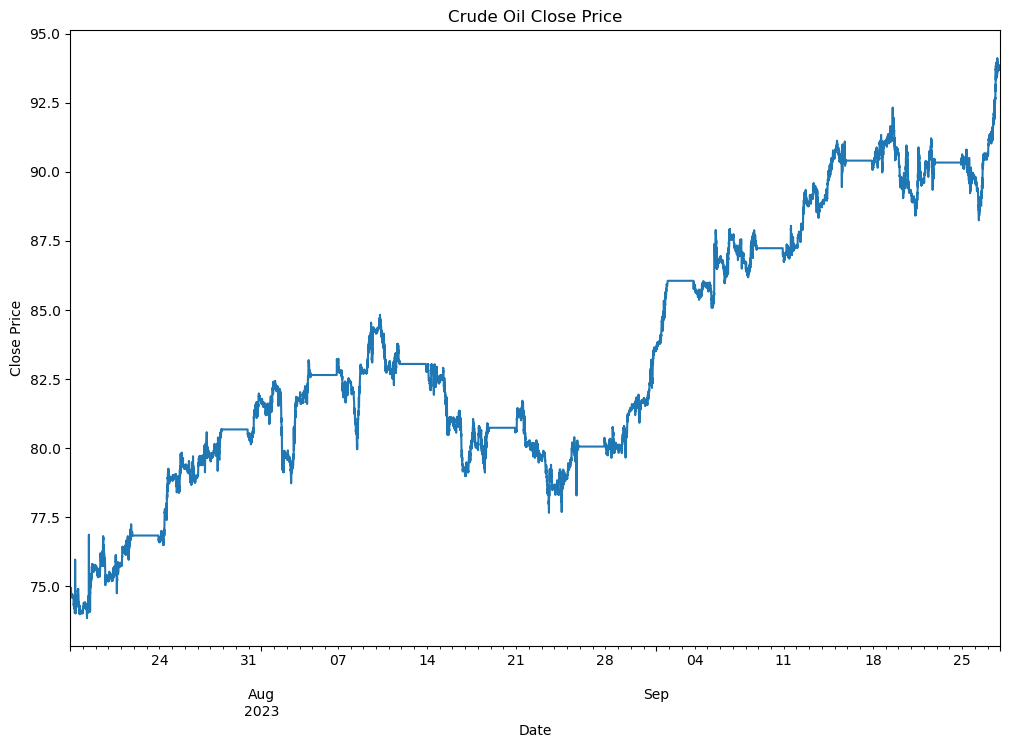

In [4]:
ax = df['Close'].plot(figsize=(12,8), title = 'Crude Oil Close Price',legend=False)
ax.set(xlabel='Date',ylabel='Close Price')

# 5. Train-test Split

We are using the 5-min chart for trades. Each day has 24*60/5 = 288 Bars. We define the variables train_length = length of each training set (≡𝑁), and test_span = length of each test set (≡𝑛). The way we divide the data into training sets and test sets is as follows:

The first N data points in the dataset are used for training, where we use the first N to predict the next n. This is the first training set of X_test = N and y_test = n. The next set will start from the entry N+n up to 2N+n, and will predict the entries from 2N+n+1 to 2N+2n. Thus, the stride is = n. This process continues.

In [5]:
# The overall training data is the whole dataset, whereas the test data does not cover the first training length
# we take the stride to be equal to the test span for convenience
train_length = 288
test_span = 10

train = pd.DataFrame(df.iloc[:]['Close'])
test = pd.DataFrame(df.iloc[test_span:]['Close'])

In [6]:
# Create a function that takes in train data and test data, in addition
# to the training length and the test span, it should return training sets made on len(X_train) = train_length, 
# and len(y_train) = test_span. The last equality is chosen for convenience and does not have to hold.

def train_test_split(train, test, train_length, test_span):
    
    # Define empty lists to filled by X_train and y_train afrom training data, and X_test from test data.
    X_train = []
    y_train = []
    X_test = []
    
    # Since each scaler is fit to the current X_train, we need to keep all of them in a list for the 
    # purposes of inverse-transforming the corresponding predictions
    scalers = []
    
    # Rescale current training data batch. We loop over the number of the training sets,
    for i in range(1+int((len(train)-train_length-test_span)/test_span)):
        current_scaler = MinMaxScaler()
        current_scaler.fit(train[i*test_span:i*test_span+train_length])
        scalers.append(current_scaler)
        
        current_scaled_X_train = current_scaler.transform(train[i*test_span:i*test_span+train_length])
        X_train.append(current_scaled_X_train)
        
        current_scaled_y_train = current_scaler.transform(train[i*test_span+train_length:(i+1)*test_span+train_length])
        y_train.append(current_scaled_y_train)
        
        
        current_scaled_X_test = current_scaler.transform(test[i*test_span:i*test_span+train_length])
        X_test.append(current_scaled_X_test)
        
        
    
    # Convert X_train, y_train and X_test into numpy arrays, then reshape X_train and y_train to be 
    # as required by the network
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
     
    
    X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) 
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) 
    return X_train, y_train, X_test, scalers

In [7]:
X_train, y_train, X_test, scalers = train_test_split(train, test, train_length, test_span)

In [8]:
print("The number of training sets is: " + str(len(X_train)))
print(f"The size of X_train in each training set is {len(X_train[0])}, whereas the size of y_train is {len(y_train[0])}")
print("The number of test sets is: " + str(len(X_test)))
print(f"There are {len(scalers)} scalers, on for each training set.")

The number of training sets is: 2073
The size of X_train in each training set is 288, whereas the size of y_train is 10
The number of test sets is: 2073
There are 2073 scalers, on for each training set.


In [9]:
print("Shape of X_train is: " + str(X_train.shape))
print("Shape of y_train is: " + str(y_train.shape))
print("Shape of X_test is: " + str(X_test.shape))

Shape of X_train is: (2073, 288, 1)
Shape of y_train is: (2073, 10, 1)
Shape of X_test is: (2073, 288, 1)


# 6. Train and Make Predictions

We write a function that takes in X_train, y_train, X_test and the corresponding scaler, then trains the network, makes predictions based on X_test, and then rescales them back to actual prices

2024-02-01 10:56:48.986797: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 60s 906ms/step


Text(0, 0.5, 'Losses')

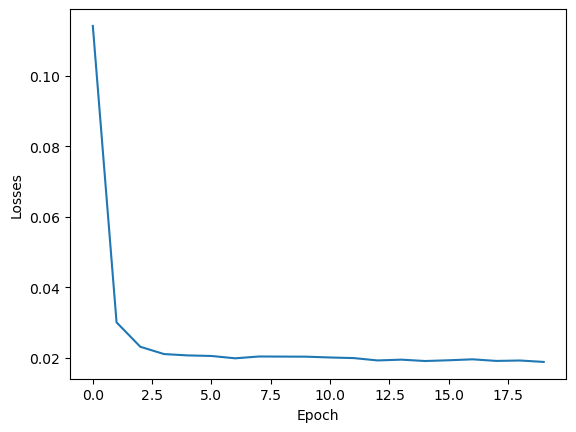

In [10]:
# Define the function

def BLSTM_DAE_model(X_train, y_train, X_test, scalers):
    
    BLSTM_DAE_model = Sequential()
    
    # DAE part
    BLSTM_DAE_model.add(Dense(256,activation='tanh'))
    BLSTM_DAE_model.add(Dense(128,activation='tanh'))
    BLSTM_DAE_model.add(Dense(128,activation='tanh'))
    BLSTM_DAE_model.add(Dense(256,activation='tanh'))
    
    # BLSTM part
    BLSTM_DAE_model.add(Bidirectional(LSTM(units=300, return_sequences=True, input_shape=(X_train.shape[1],1),activation='tanh')))
    BLSTM_DAE_model.add(Bidirectional(LSTM(units=300, activation='tanh')))
    BLSTM_DAE_model.add(Dense(units=test_span))
    
    # Compile and fit
    BLSTM_DAE_model.compile(optimizer='adam',loss='mse')
    BLSTM_DAE_model.fit(X_train,y_train,epochs=20,batch_size=150,verbose=0)
    
    
    # Evaluate loss per epoch and append to list
    losses = []
    loss = BLSTM_DAE_model.history.history['loss']
    losses.append(loss)
    
    # Make predictions based on scaled data
    predictions = BLSTM_DAE_model.predict(X_test)
    
    # Rescale predictions into actual prices, where each set of predictions to be rescaled 
    # using its own scaler
    true_predictions = []

    
    for i in range(len(scalers)):
        # Make predictions and append to list of predictions
        current_true_pred = list(np.round(scalers[i].inverse_transform([predictions[i]])[0],2))
        for j in current_true_pred:
            true_predictions.append(j)

    
    
    return BLSTM_DAE_model, losses, true_predictions

BLSTM_DAE_model, losses, true_predictions = BLSTM_DAE_model(X_train, y_train, X_test,scalers)
plt.plot(losses[0])
plt.xlabel('Epoch')
plt.ylabel('Losses')

In [11]:
BLSTM_DAE_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288, 256)          512       
                                                                 
 dense_1 (Dense)             (None, 288, 128)          32896     
                                                                 
 dense_2 (Dense)             (None, 288, 128)          16512     
                                                                 
 dense_3 (Dense)             (None, 288, 256)          33024     
                                                                 
 bidirectional (Bidirectiona  (None, 288, 600)         1336800   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 600)              2162400   
 nal)                                                   

Here, we create a DataFrame of the predictions in addition to the actual close prices

In [12]:
# Prepare DataFrame of actual close prices for the test period
df_actual_preds = pd.DataFrame(df.iloc[train_length+test_span:]['Close'])
df_actual_preds['Predictions'] = np.nan

# Fill in the predictions
for i in range(len(df_actual_preds['Close'])):
    df_actual_preds.iloc[i:i+1,[1]] = true_predictions[i]

df_actual_preds.head()

,Close,Predictions
Datetime,,
2023-07-18 00:55:00,74.26,74.21
2023-07-18 01:00:00,74.23,74.22
2023-07-18 01:05:00,74.25,74.24
2023-07-18 01:10:00,74.34,74.23
2023-07-18 01:15:00,74.33,74.20


# 7. Evaluating and Visualizing Predictions 

In [13]:
# Caluclaue differences between predictions and actual close price, then find the %diff
df_actual_preds['Diff'] = df_actual_preds['Predictions']-df_actual_preds['Close']
df_actual_preds['%Diff'] = np.round(100*df_actual_preds['Diff']/df_actual_preds['Close'],2)
df_actual_preds.head()

,Close,Predictions,Diff,%Diff
Datetime,,,,
2023-07-18 00:55:00,74.26,74.21,-0.05,-0.07
2023-07-18 01:00:00,74.23,74.22,-0.01,-0.01
2023-07-18 01:05:00,74.25,74.24,-0.01,-0.01
2023-07-18 01:10:00,74.34,74.23,-0.11,-0.15
2023-07-18 01:15:00,74.33,74.20,-0.13,-0.17


In [14]:
# Find MAE, RMSE, MAPE and R^2 of predictions and actual close price
print('RMSE of Close Price predictions:' + str(np.round(np.sqrt(mean_squared_error(df_actual_preds['Predictions'],df_actual_preds['Close'])),4)))
print('MAE of Close Price predictions:' + str(np.round(mean_absolute_error(df_actual_preds['Predictions'],df_actual_preds['Close']),4)))
print('MAPE of Close Price predictions:' + str(np.round(mean_absolute_percentage_error(df_actual_preds['Predictions'],df_actual_preds['Close']),4)))
print('R^2 of Close Price predictions:' + str(np.round(r2_score(df_actual_preds['Predictions'],df_actual_preds['Close']),4)))

RMSE of Close Price predictions:0.1618
MAE of Close Price predictions:0.0952
MAPE of Close Price predictions:0.0011
R^2 of Close Price predictions:0.9987


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.3000e+01, 2.8000e+01, 1.3700e+02,
        3.6100e+02, 1.2780e+03, 7.2020e+03, 1.0318e+04, 1.0230e+03,
        2.5200e+02, 7.0000e+01, 3.3000e+01, 3.0000e+00, 3.0000e+00]),
 array([-2.44  , -2.2535, -2.067 , -1.8805, -1.694 , -1.5075, -1.321 ,
        -1.1345, -0.948 , -0.7615, -0.575 , -0.3885, -0.202 , -0.0155,
         0.171 ,  0.3575,  0.544 ,  0.7305,  0.917 ,  1.1035,  1.29  ]),
 <BarContainer object of 20 artists>)

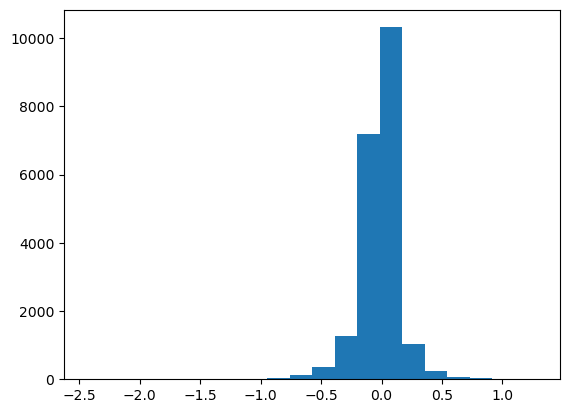

In [15]:
# Plot distribution of differences
plt.hist(df_actual_preds['Diff'],bins=20)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 4.0000e+00, 2.2000e+01, 9.1000e+01,
        2.4500e+02, 9.9800e+02, 5.1160e+03, 1.2608e+04, 1.2770e+03,
        2.4700e+02, 8.1000e+01, 2.6000e+01, 4.0000e+00, 3.0000e+00]),
 array([-3.17  , -2.9305, -2.691 , -2.4515, -2.212 , -1.9725, -1.733 ,
        -1.4935, -1.254 , -1.0145, -0.775 , -0.5355, -0.296 , -0.0565,
         0.183 ,  0.4225,  0.662 ,  0.9015,  1.141 ,  1.3805,  1.62  ]),
 <BarContainer object of 20 artists>)

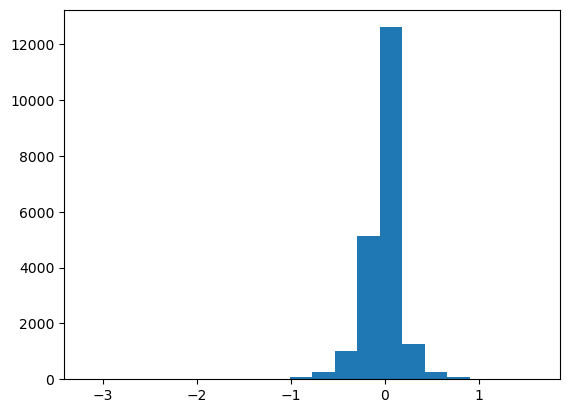

In [16]:
# Plot distribution of %difference
plt.hist(df_actual_preds['%Diff'],bins=20)

### Overall Predictions vs. Actual Prices 

[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

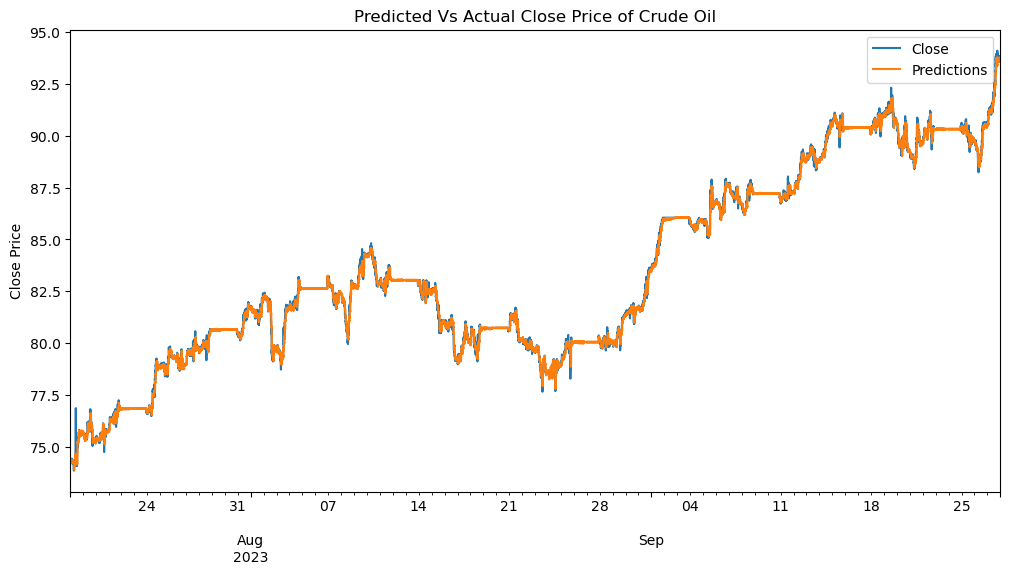

In [17]:
# Plot predictions against known values
title = 'Predicted Vs Actual Close Price of Crude Oil'
ylabel='Close Price'
xlabel='' # we don't really need a label here

ax = df_actual_preds['Close'].plot(legend=True,figsize=(12,6),title=title)
df_actual_preds['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### One Month Close-up

[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

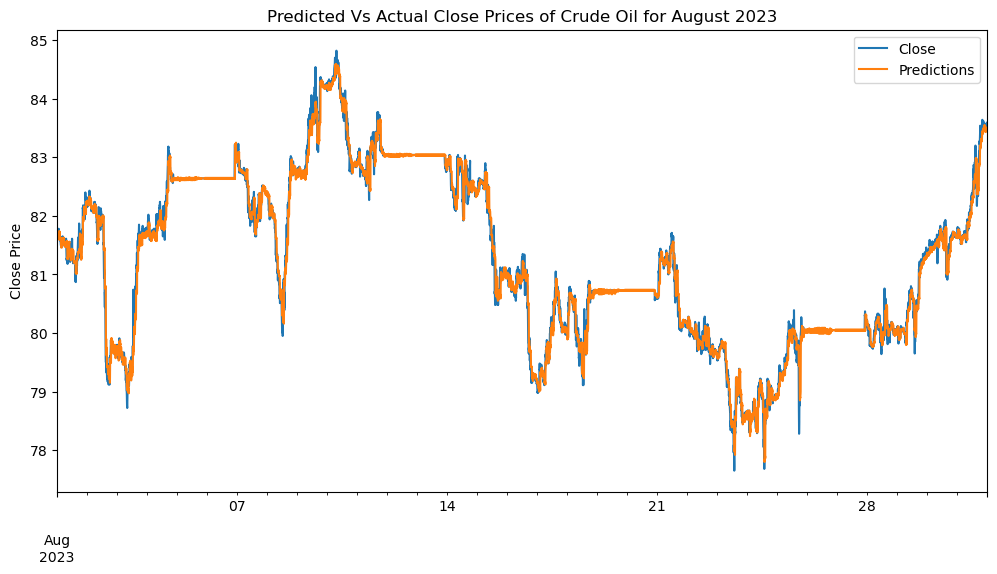

In [18]:
# Make a plot for the month of August
start = '2023-08-01 00:00:00'
end = '2023-08-31 23:55:00'

# Plot predictions against known values
title = 'Predicted Vs Actual Close Prices of Crude Oil for August 2023'
ylabel='Close Price'
xlabel='' # we don't really need a label here

ax = df_actual_preds.loc[start:end]['Close'].plot(legend=True,figsize=(12,6),title=title)
df_actual_preds.loc[start:end]['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### 5-Day Close-up  

[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

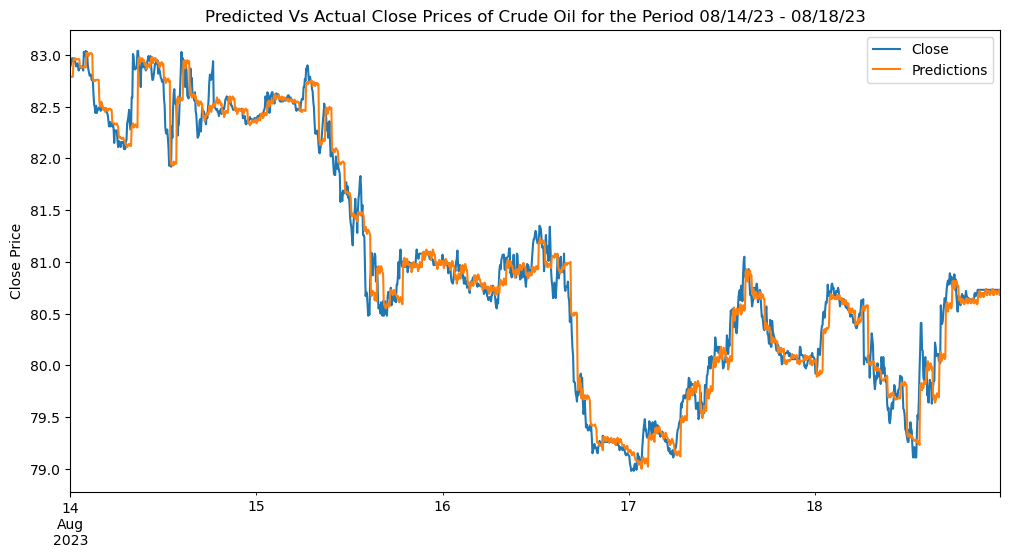

In [19]:
# Make a plot for 5-days from 08/14/23 - 08/18/23
start = '2023-08-14 00:00:00'
end = '2023-08-18 23:55:00'

title = 'Predicted Vs Actual Close Prices of Crude Oil for the Period 08/14/23 - 08/18/23'
ylabel='Close Price'
xlabel='' 

ax = df_actual_preds[start:end]['Close'].plot(legend=True,figsize=(12,6),title=title)
df_actual_preds[start:end]['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### One Day Close-up 

[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

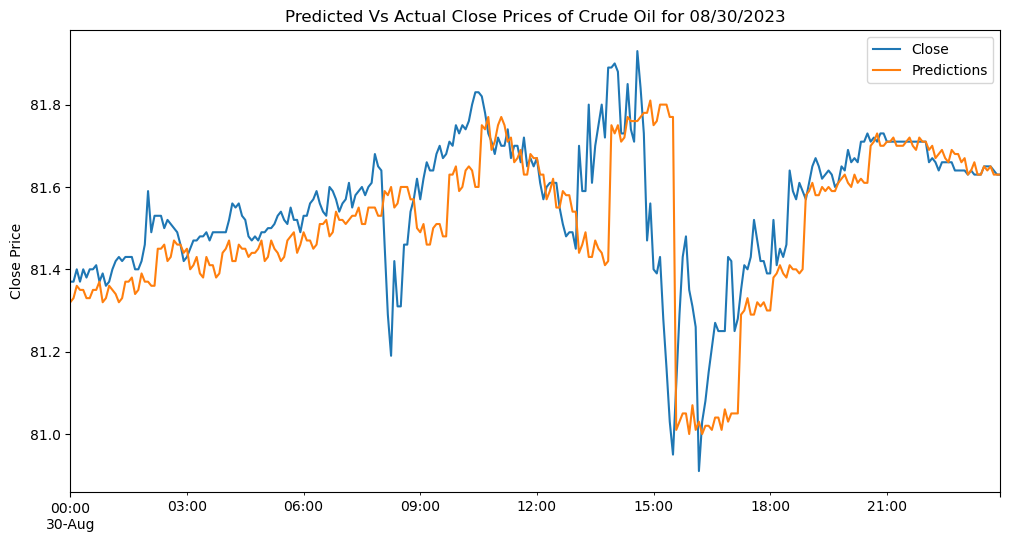

In [20]:
# Make a plot for the 30th of August
start = '2023-08-30 00:00:00'
end = '2023-08-30 23:55:00'

# Plot predictions against known values
title = 'Predicted Vs Actual Close Prices of Crude Oil for 08/30/2023'
ylabel='Close Price'
xlabel='' 

ax = df_actual_preds[start:end]['Close'].plot(legend=True,figsize=(12,6),title=title)
df_actual_preds[start:end]['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

# 8. Future Forecast

### Make Forecast 

In [21]:
train_length = 288
test_span = 10

forecast_train = pd.DataFrame(df.iloc[-(train_length+test_span):]['Close'])
forecast_test = pd.DataFrame(df.iloc[-train_length:]['Close'])

X_train_forecast, y_train_forecast, X_test_forecast, scaler = train_test_split(forecast_train, forecast_test, train_length, test_span)

1/1 [==============================] - 0s 460ms/step
--- 12.865892887115479 seconds ---


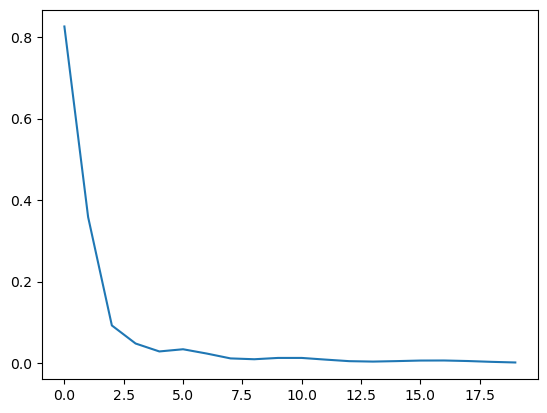

In [22]:
# Define the function

def BLSTM_DAE_model(X_train, y_train, X_test, scalers):
    
    BLSTM_DAE_model = Sequential()
    
    # DAE part
    BLSTM_DAE_model.add(Dense(256,activation='tanh'))
    BLSTM_DAE_model.add(Dense(128,activation='tanh'))
    BLSTM_DAE_model.add(Dense(128,activation='tanh'))
    BLSTM_DAE_model.add(Dense(256,activation='tanh'))
    
    # BLSTM part
    BLSTM_DAE_model.add(Bidirectional(LSTM(units=300, return_sequences=True, input_shape=(X_train.shape[1],1),activation='tanh')))
    BLSTM_DAE_model.add(Bidirectional(LSTM(units=300, activation='tanh')))
    BLSTM_DAE_model.add(Dense(units=test_span))
    
    # Compile and fit
    BLSTM_DAE_model.compile(optimizer='adam',loss='mse')
    BLSTM_DAE_model.fit(X_train,y_train,epochs=20,batch_size=150,verbose=0)
    
    
    # Evaluate loss per epoch and append to list
    losses = []
    loss = BLSTM_DAE_model.history.history['loss']
    losses.append(loss)
    
    # Make predictions based on scaled data
    predictions = BLSTM_DAE_model.predict(X_test)
    
    # Rescale predictions into actual prices, where each set of predictions to be rescaled 
    # using its own scaler
    true_predictions = []

    
    for i in range(len(scalers)):
        # Make predictions and append to list of predictions
        current_true_pred = list(np.round(scalers[i].inverse_transform([predictions[i]])[0],2))
        for j in current_true_pred:
            true_predictions.append(j)

    
    
    return BLSTM_DAE_model, losses, true_predictions

# Measure Time
start_time = time.time()
BLSTM_DAE_model, losses, true_predictions = BLSTM_DAE_model(X_train_forecast, y_train_forecast, X_test_forecast, scaler)
plt.plot(losses[0])
print("--- %s seconds ---" % (time.time() - start_time))

RMSE of Close Price predictions:0.32
MAE of Close Price predictions:0.27
MAPE of Close Price predictions:0.0029
R^2 of Close Price predictions:-6.9131


[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

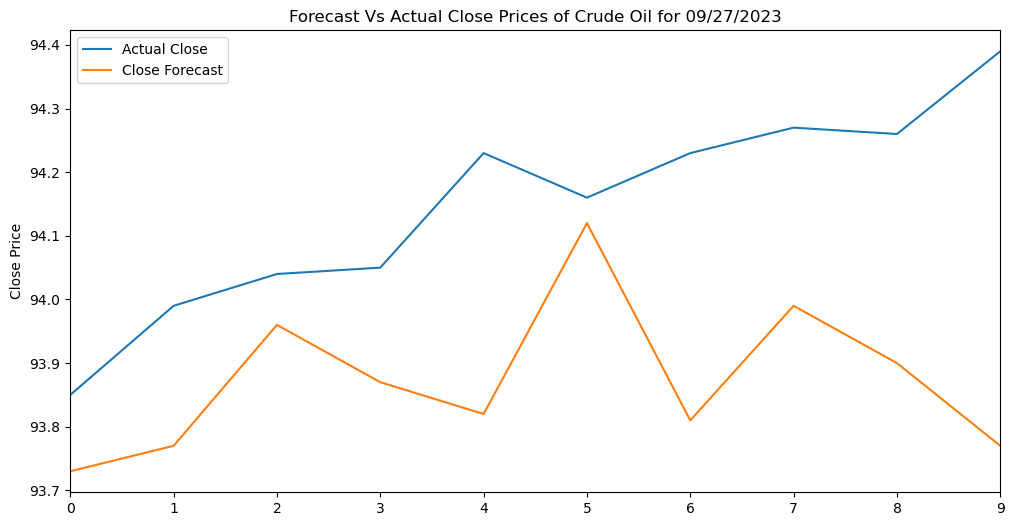

In [23]:
# Prepare DataFrame of actual close prices for the test period
actual_close_data = [93.85, 93.99, 94.04, 94.05, 94.23, 94.16, 94.23, 94.27, 94.26, 94.39]
df_forecast = pd.DataFrame(actual_close_data,columns=['Actual Close'])
df_forecast['Close Forecast'] = np.nan


# Fill in the predictons
for i in range(len(df_forecast)):
    df_forecast.iloc[i:i+1,[1]] = true_predictions[i]

    
# Compare with actual prices
df_forecast['Diff'] = df_forecast['Close Forecast']- df_forecast['Actual Close']
df_forecast['%Diff'] = np.round(100*(df_forecast['Close Forecast']- df_forecast['Actual Close'])/df_forecast['Actual Close'],2)
                     

## Find MAE, RMSE, MAPE, R^2 of forecast and actual close price
print('RMSE of Close Price predictions:' + str(np.round(np.sqrt(mean_squared_error(df_forecast['Close Forecast'],df_forecast['Actual Close'])),2)))
print('MAE of Close Price predictions:' + str(np.round(mean_absolute_error(df_forecast['Close Forecast'],df_forecast['Actual Close']),2)))
print('MAPE of Close Price predictions:' + str(np.round(mean_absolute_percentage_error(df_forecast['Close Forecast'],df_forecast['Actual Close']),4)))
print('R^2 of Close Price predictions:' + str(np.round(r2_score(df_forecast['Close Forecast'],df_forecast['Actual Close']),4)))

# Plot Comparison
title = 'Forecast Vs Actual Close Prices of Crude Oil for 09/27/2023'
ylabel='Close Price'
xlabel='' # we don't really need a label here

ax = df_forecast['Actual Close'].plot(legend=True,figsize=(12,6),title=title)
df_forecast['Close Forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)